# Testing for genotype without considering disease time

### Logistics

In [1]:
#install libraries if not already
%pip install -r ../requirements.txt
%clear


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# load necessary library
import os
import pandas as pd
import numpy as np
from pipeline import ClusterFeatures,LBP_3D,XGBoost,XGBoostP,create_report_summary,NaiveBayesP,NaiveBayes,SVM,SVMP
from sklearn.model_selection import train_test_split


In [3]:
# load dataset
csv_dir = '../../Datasets/Rat PA Study/CSV/'
csv_files = [file for file in os.listdir(csv_dir) if file.endswith('.csv')]

dataframes = []
for file in csv_files:
    file_path = os.path.join(csv_dir, file)
    dataframes.append([pd.read_csv(file_path),file_path])


#load report features
source = '../../Datasets/Rat PA Study/PDF_reports/'

# Check if the folder exists
if not os.path.exists(source):
    print(f"The folder {source} does not exist.")
else:
    print(f"Folder {source} found.")


report_summary = create_report_summary(source)


for idx,row in enumerate(dataframes):
    path=row[1].split('/')[5].split('.')[0]
    report_row = report_summary[report_summary['ScanName']==path]
    report_row=report_row.drop(columns=['ScanName','DatePrepared','FileName'])
    dataframes[idx].append(report_row)



Folder ../../Datasets/Rat PA Study/PDF_reports/ found.


In [4]:
#split data by genotypes
CF=[]
CF_report=[]

KO=[]
KO_report=[]

WT=[]
WT_report=[]

for df,path,report in dataframes:
    if 'WT' in path:
        WT.append(df)
        WT_report.append(report)
    if 'KO' in path:
        KO.append(df)
        KO_report.append(report)
    if 'CF' in path:
        CF.append(df)
        CF_report.append(report)


print(f'{len(CF)} CF rats, {len(KO)} KO rats, {len(WT)} WT rats ')

16 CF rats, 17 KO rats, 19 WT rats 


# Modelling and Classification

### Using LBP

In [5]:
data=[]

for d in CF:
    d.columns=['SV','X','Y','Z']
    data.append([d,1])
for d in KO:
    d.columns=['SV','X','Y','Z']
    data.append([d,2])
for d in WT:
    d.columns=['SV','X','Y','Z']
    data.append([d,0])




lbp=LBP_3D(data)
features=lbp.extract()


In [6]:
def remove(feat,test,label):
    temp=feat[feat['Label']==label]
    t=temp.sample(n=1, random_state=np.random.randint(0, 1000))

    feat=feat.drop(t.index)
    test=pd.concat([test,t],ignore_index=True)

test=pd.DataFrame()

remove(features,test,0)
remove(features,test,1)
remove(features,test,2)




In [7]:
labels=features['Label']
features=features.drop(columns=['Label'])
features=features.apply(pd.to_numeric, errors='coerce')

features.fillna(0,inplace=True)

In [8]:

X_train, X_test, y_train, y_test = train_test_split(features.values, labels, test_size=0.2, random_state=42,stratify=labels)



Classification Report: XGBoost
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.50      1.00      0.67         3
           2       0.67      0.50      0.57         4

    accuracy                           0.45        11
   macro avg       0.39      0.50      0.41        11
weighted avg       0.38      0.45      0.39        11

True: 0, Pred: 1, Probabilities: [0.06673479 0.5896604  0.34360483]
True: 1, Pred: 1, Probabilities: [0.0345239  0.95372194 0.01175415]
True: 0, Pred: 1, Probabilities: [0.03536157 0.94718975 0.01744862]
True: 1, Pred: 1, Probabilities: [0.19638966 0.79497355 0.0086368 ]
True: 0, Pred: 1, Probabilities: [0.31501663 0.6357957  0.04918761]
True: 2, Pred: 2, Probabilities: [0.13273998 0.33153754 0.53572243]
True: 2, Pred: 2, Probabilities: [0.03721525 0.03317815 0.92960656]
True: 1, Pred: 1, Probabilities: [0.24396825 0.6512175  0.10481416]
True: 2, Pred: 0, Probabilities: [0.8859345 

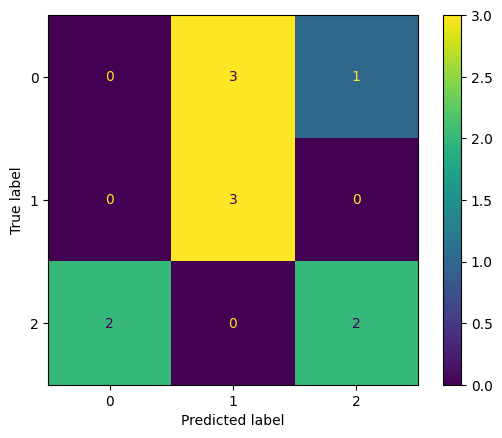

In [9]:
modelXG=XGBoost(X_train,y_train,X_test,y_test,True)
modelXGP=XGBoostP(X_train,y_train,X_test,y_test,True)

Classification Report: Naive Bayes (GaussianNB)
              precision    recall  f1-score   support

           0       0.40      0.50      0.44         4
           1       0.50      0.67      0.57         3
           2       0.50      0.25      0.33         4

    accuracy                           0.45        11
   macro avg       0.47      0.47      0.45        11
weighted avg       0.46      0.45      0.44        11

True: 0, Pred: 2, Probabilities: [0.05522359 0.06292742 0.88184899]
True: 1, Pred: 1, Probabilities: [5.39711146e-09 9.99999995e-01 1.07547865e-18]
True: 0, Pred: 1, Probabilities: [2.52167694e-08 9.99999975e-01 1.22222727e-18]
True: 1, Pred: 1, Probabilities: [4.19977809e-05 9.99958002e-01 1.35563983e-16]
True: 0, Pred: 0, Probabilities: [9.99539145e-01 4.60854714e-04 7.30339903e-14]
True: 2, Pred: 0, Probabilities: [7.18164580e-01 2.81601803e-01 2.33617155e-04]
True: 2, Pred: 2, Probabilities: [7.1063944e-11 5.0968738e-15 1.0000000e+00]
True: 1, Pred: 0, Probabil

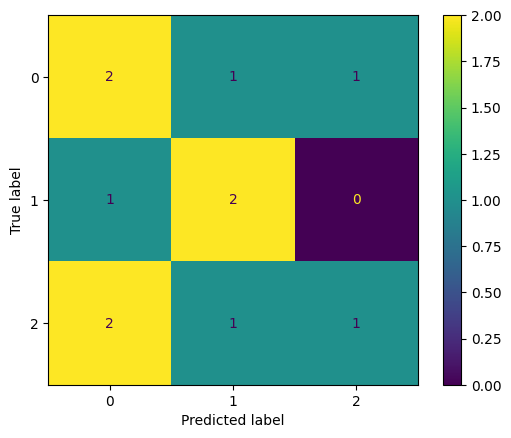

In [10]:
model=NaiveBayes(X_train,y_train,X_test,y_test,True)
modelP=NaiveBayesP(X_train,y_train,X_test,y_test,True)

Classification Report: SVC
              precision    recall  f1-score   support

           0       0.36      1.00      0.53         4
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         4

    accuracy                           0.36        11
   macro avg       0.12      0.33      0.18        11
weighted avg       0.13      0.36      0.19        11

True: 0, Pred: 0, Probabilities: [0.33468635 0.37291558 0.29239807]
True: 1, Pred: 0, Probabilities: [0.30325268 0.27988544 0.41686188]
True: 0, Pred: 0, Probabilities: [0.30646192 0.3056667  0.38787138]
True: 1, Pred: 0, Probabilities: [0.3237274  0.25408359 0.42218901]
True: 0, Pred: 0, Probabilities: [0.29106688 0.33643048 0.37250264]
True: 2, Pred: 0, Probabilities: [0.29223809 0.40842248 0.29933944]
True: 2, Pred: 0, Probabilities: [0.33595339 0.40398334 0.26006327]
True: 1, Pred: 0, Probabilities: [0.36175111 0.28438169 0.3538672 ]
True: 2, Pred: 0, Probabilities: [0.30769242 0.4

/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

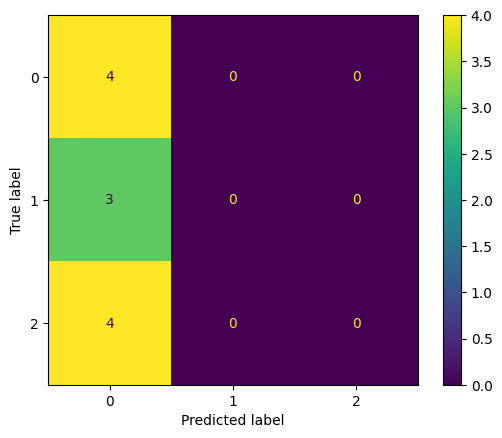

In [11]:
modelSVM=SVM(X_train,y_train,X_test,y_test,True)
modelSVWP=SVMP(X_train,y_train,X_test,y_test,True)

## Using report features

In [12]:
r_feat=pd.DataFrame()

for d in CF_report:
    d['Label']=1
    r_feat=pd.concat([r_feat,d],ignore_index=True)
for d in WT_report:
    d['Label']=0
    r_feat=pd.concat([r_feat,d],ignore_index=True)
for d in KO_report:
    d['Label']=2
    r_feat=pd.concat([r_feat,d],ignore_index=True)




In [13]:
test_r=pd.DataFrame()
remove(r_feat,test,0)

remove(r_feat,test,1)
remove(r_feat,test,2)


In [14]:
labels=r_feat['Label']
r_feat=r_feat.drop(columns=['Label'])
r_feat=r_feat.apply(pd.to_numeric, errors='coerce')

r_feat.fillna(0,inplace=True)



In [15]:

X_train, X_test, y_train, y_test = train_test_split(features.values, labels, test_size=0.2, random_state=42,stratify=labels)


Classification Report: XGBoost
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.50      0.67      0.57         3
           2       0.33      0.25      0.29         4

    accuracy                           0.55        11
   macro avg       0.53      0.56      0.54        11
weighted avg       0.53      0.55      0.53        11

True: 0, Pred: 0, Probabilities: [0.5000282  0.39542    0.10455182]
True: 1, Pred: 1, Probabilities: [0.00660139 0.7205015  0.2728971 ]
True: 0, Pred: 0, Probabilities: [0.6863141  0.1378607  0.17582515]
True: 1, Pred: 1, Probabilities: [0.04165023 0.72116405 0.23718572]
True: 0, Pred: 0, Probabilities: [0.98191637 0.00815129 0.00993231]
True: 2, Pred: 1, Probabilities: [0.1879546  0.56008524 0.25196013]
True: 2, Pred: 2, Probabilities: [0.40767372 0.12117702 0.4711492 ]
True: 1, Pred: 2, Probabilities: [0.01565685 0.43452355 0.54981965]
True: 2, Pred: 0, Probabilities: [0.4987016 

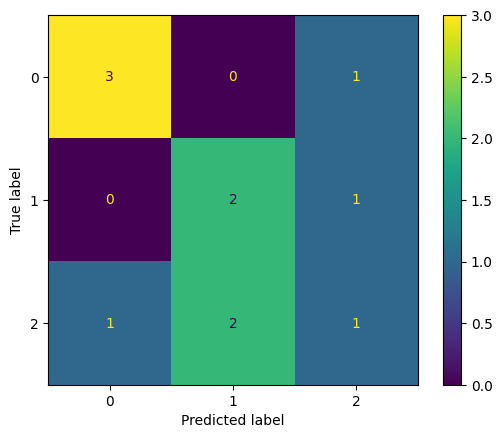

In [16]:
r_modelXG=XGBoost(X_train,y_train,X_test,y_test,True)
r_modelXGP=XGBoostP(X_train,y_train,X_test,y_test,True)

Classification Report: Naive Bayes (GaussianNB)
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.75      1.00      0.86         3
           2       0.67      0.50      0.57         4

    accuracy                           0.73        11
   macro avg       0.72      0.75      0.73        11
weighted avg       0.72      0.73      0.71        11

True: 0, Pred: 0, Probabilities: [9.99999953e-01 4.65391360e-08 1.05876472e-14]
True: 1, Pred: 1, Probabilities: [2.92102121e-17 9.96025525e-01 3.97447454e-03]
True: 0, Pred: 0, Probabilities: [0.57461599 0.41370307 0.01168094]
True: 1, Pred: 1, Probabilities: [5.75468700e-12 1.00000000e+00 1.43058243e-14]
True: 0, Pred: 0, Probabilities: [1.00000000e+00 5.15531981e-11 4.22292887e-13]
True: 2, Pred: 2, Probabilities: [6.79478322e-07 3.68304287e-02 9.63168892e-01]
True: 2, Pred: 0, Probabilities: [9.99874747e-01 1.24614322e-04 6.38971194e-07]
True: 1, Pred: 1, Proba

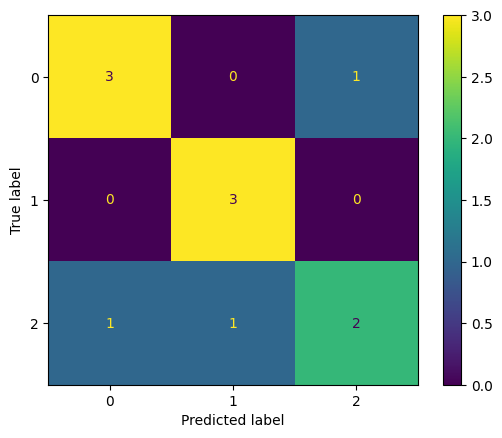

In [17]:
r_model=NaiveBayes(X_train,y_train,X_test,y_test,True)
r_modelP=NaiveBayesP(X_train,y_train,X_test,y_test,True)

Classification Report: SVC
              precision    recall  f1-score   support

           0       0.57      1.00      0.73         4
           1       0.67      0.67      0.67         3
           2       0.00      0.00      0.00         4

    accuracy                           0.55        11
   macro avg       0.41      0.56      0.46        11
weighted avg       0.39      0.55      0.45        11

True: 0, Pred: 0, Probabilities: [0.30685576 0.33486805 0.35827618]
True: 1, Pred: 2, Probabilities: [0.43282005 0.31071156 0.25646838]
True: 0, Pred: 0, Probabilities: [0.31770262 0.36511852 0.31717885]
True: 1, Pred: 1, Probabilities: [0.41665222 0.28280951 0.30053827]
True: 0, Pred: 0, Probabilities: [0.25739112 0.37788365 0.36472523]
True: 2, Pred: 0, Probabilities: [0.3697034 0.3369085 0.2933881]
True: 2, Pred: 0, Probabilities: [0.31857924 0.33562211 0.34579865]
True: 1, Pred: 1, Probabilities: [0.3710568  0.28332408 0.34561912]
True: 2, Pred: 1, Probabilities: [0.40062669 0.3102

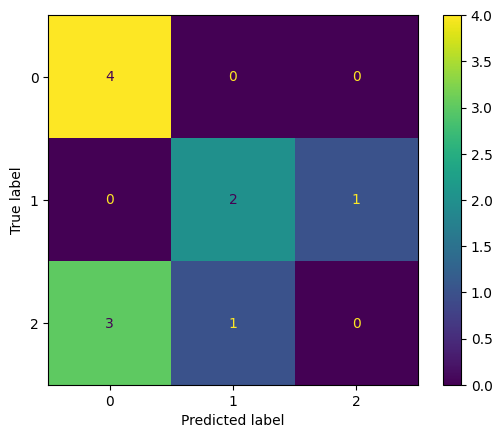

In [18]:
r_modelSVM=SVM(X_train,y_train,X_test,y_test,True)
r_modelSVWP=SVMP(X_train,y_train,X_test,y_test,True)